# `DataLoader` guide

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/grain/blob/main/docs/tutorials/data_loader_tutorial.ipynb)

## Install Grain and tutorial dependencies

In [ ]:
!pip install grain tfds-nightly opencv-python matplotlib orbax-checkpoint

import cv2
import orbax.checkpoint as ocp
import grain.python as grain
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ.pop('TFDS_DATA_DIR', None)
import tensorflow_datasets as tfds

## Concepts
The `DataLoader` class is responsible for reading and transforming input data records. Users need to iterate through the `DataLoader` to get output elements.

The `DataLoader` uses a **Sampler** to determine which records to read next, a **DataSource** to read the records, and applies **Transformations** to the read records to produce output elements. We present these concepts in the following sections.

## `Sampler`
A `Sampler` is responsible for determining which records to read next. This involves applying global transformations such as shuffling records, repeating for multiple epochs and sharding across multiple machines. The sampler is an `Iterator` which produces metadata objects containing the following information:
* `index`: a monotonically increasing number, unique for each record. It keeps track of the pipeline process and will be used for checkpointing.
* `record_key`: a reference to the record in the serialized file format.
* `rng`: a per-record Random Number Generator to apply random transformations.

Grain provides an `IndexSampler` implementation, which we explore below.

In [ ]:
# Setting `num_records` to 5 to limit results.
# For full dataset, set to `len(data_source)`.
index_sampler_example = grain.IndexSampler(
    num_records=5,
    num_epochs=2,
    shard_options=grain.ShardOptions(
        shard_index=0, shard_count=1, drop_remainder=True),
    shuffle=True,
    seed=0)

# Iterator is consumed.
for record_metadata in index_sampler_example:
  print(record_metadata)

# Create new iterator.
index_sampler = grain.IndexSampler(
    num_records=5,
    num_epochs=2,
    shard_options=grain.ShardOptions(
        shard_index=0, shard_count=1, drop_remainder=True),
    shuffle=True,
    seed=0)

RecordMetadata(index=0, record_key=0, rng=Generator(Philox))
RecordMetadata(index=1, record_key=4, rng=Generator(Philox))
RecordMetadata(index=2, record_key=1, rng=Generator(Philox))
RecordMetadata(index=3, record_key=2, rng=Generator(Philox))
RecordMetadata(index=4, record_key=3, rng=Generator(Philox))
RecordMetadata(index=5, record_key=1, rng=Generator(Philox))
RecordMetadata(index=6, record_key=2, rng=Generator(Philox))
RecordMetadata(index=7, record_key=3, rng=Generator(Philox))
RecordMetadata(index=8, record_key=0, rng=Generator(Philox))
RecordMetadata(index=9, record_key=4, rng=Generator(Philox))


## Data source
A data source is responsible for reading indvidual records from underlying files / storage system. We provide the following data sources:

*   `ArrayRecordDataSource`: reads records from [ArrayRecord](go/array-record-design) files.
*   `tfds.data_source`: data source for [TFDS](https://www.tensorflow.org/datasets) datasets without a TensorFlow dependency.


Below, we show an example using a TFDS data source, but using other data sources should be similar.

## TFDS Data source

In [ ]:
# We use a small version of ImageNet data to spare disk and network
# usage for the demo. Prefer "imagenet2012"'s "train" split for a
# complete dataset.
source = tfds.data_source("imagenet_a", split="test")

print(f"# records: {len(source)}")

print(f"First record:\n{source[0]}")

# records: 7500
First record:
{'file_name': b'0.000296_bee _ bee_0.51374936.jpg', 'image': array([[[  0,   2,   6],
        [  0,   3,   7],
        [  0,   3,   9],
        ...,
        [176, 160,   3],
        [178, 166,   4],
        [179, 168,   0]],

       [[  0,   2,   6],
        [  0,   2,   6],
        [  0,   3,   9],
        ...,
        [183, 165,   5],
        [186, 171,   6],
        [186, 174,   4]],

       [[  0,   1,   8],
        [  0,   1,   8],
        [  0,   2,  11],
        ...,
        [193, 171,   7],
        [195, 177,   7],
        [196, 179,   5]],

       ...,

       [[180,  57,   0],
        [182,  65,   0],
        [183,  75,   0],
        ...,
        [183,  45,   0],
        [183,  40,   0],
        [183,  35,   0]],

       [[181,  61,   0],
        [184,  69,   2],
        [187,  81,   5],
        ...,
        [181,  42,   0],
        [179,  36,   0],
        [179,  29,   0]],

       [[183,  63,   0],
        [186,  71,   4],
        [188,  85,   

## Transformations

Grain `Transformations` represent transformations applied to input elements. We offer ready-to-use: `BatchTransform` and the following transformations in form of abstract classes:
* `MapTransform`
* `RandomMapTransform`
* `FilterTransform`

You'd need to create your concrete transformation by inheriting above classes.

**Note:**

1. Since Grain uses Python multiprocessing to parallelize work, transformation must be picklable, so they can be sent from the main process to the workers.
2. When using `BatchTransform` the `batch_size` is the global batch size if it is done before sharding, if it is done after sharding it is the batch size *per host* (this is typically the case when using `IndexSampler` with `DataLoader`).

In [ ]:
class ResizeAndCrop(grain.MapTransform):

  def map(self, element: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
    image = element["image"]
    image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
    image = image[:224, :224]
    element["image"] = image
    return element

transformations = [ResizeAndCrop()]

## `DataLoader`

`DataLoader` is the glue between `Sampler`, `DataSource` and transformations. In addition, it is responsible for launching children processes to parallelize the processing of the input pipeline, collecting output elements from these processes and gracefully shutting them down at exit. Users need to iterate through the `DataLoader` to get processed elements (typically the output batches).

For quick experimentation, use `worker_count=0`, to run everything in a single process, saving the time to setup workers. When going to real training / evaluation, increase the number of workers to parallelize processing.

In [ ]:
data_loader = grain.DataLoader(
    data_source=source,
    operations=transformations,
    sampler=index_sampler,
    worker_count=0)

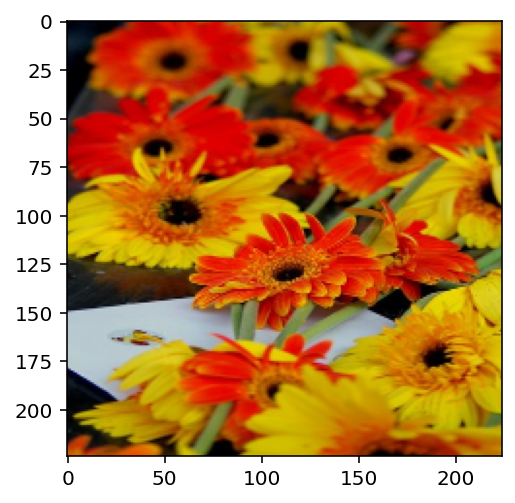

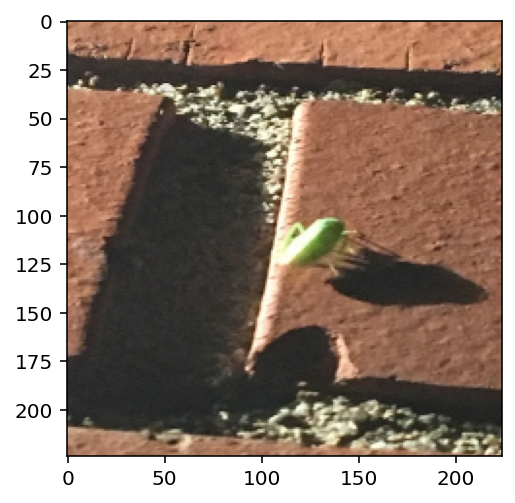

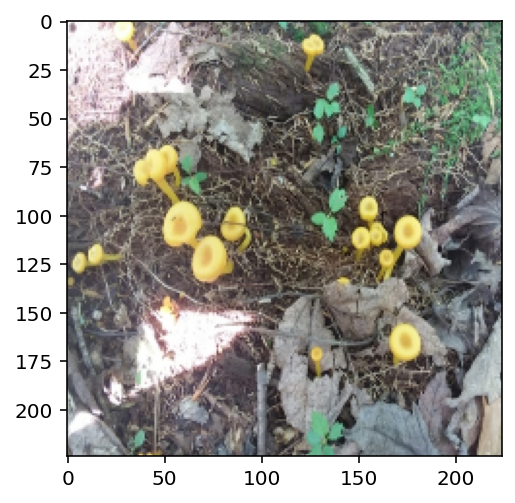

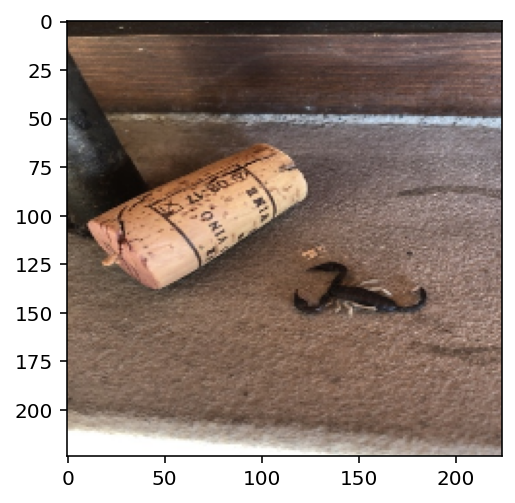

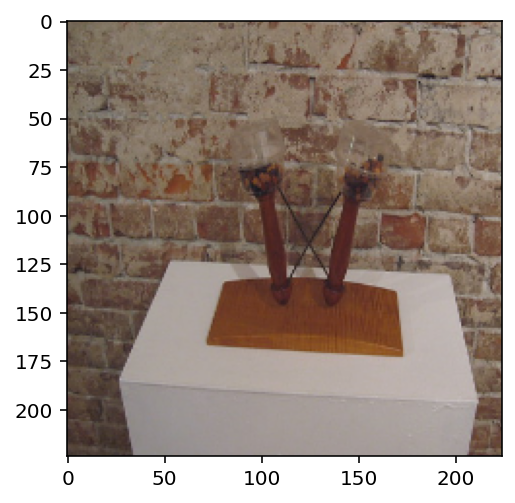

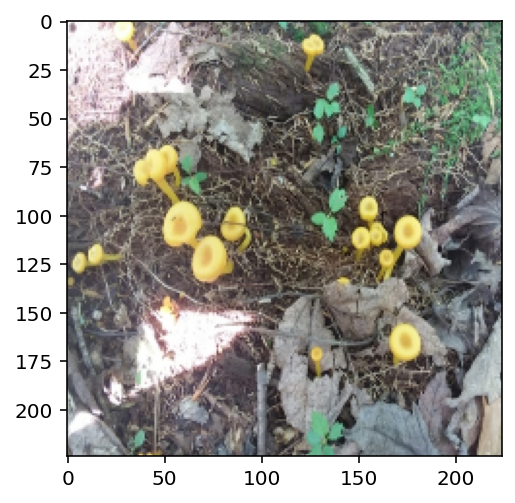

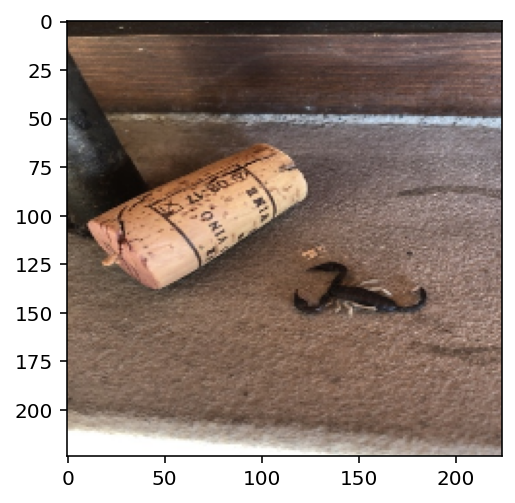

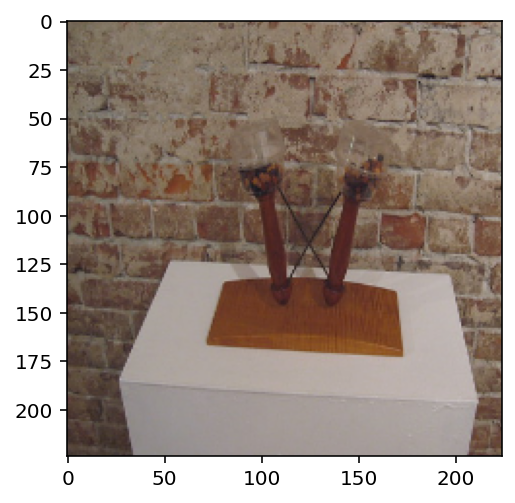

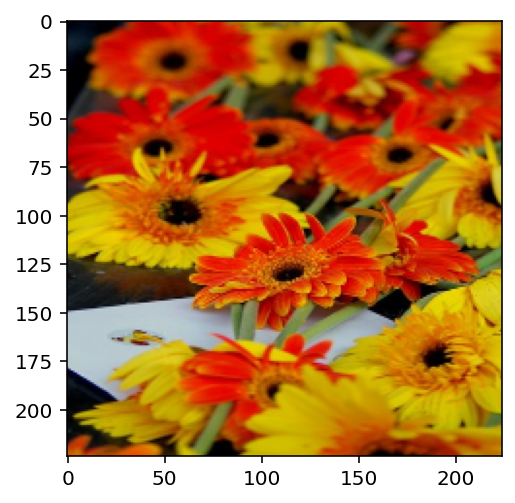

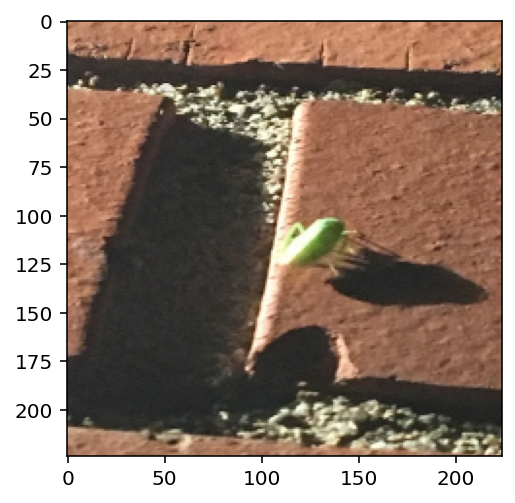

In [ ]:
for element in data_loader:
  fig = plt.figure
  plt.imshow(element["image"])
  plt.show()

## Checkpointing
We provide `PyGrainCheckpointHandler` to checkpoint the iterator returned by Grain. It is recommended to use it with [Orbax](https://orbax.readthedocs.io), which can checkpoint both input pipeline and model and handles the edge cases for distributed training.

### Integration with Orbax
Orbax contains a powerful library for checkpointing various objects - incl. Flax models and Grain `DatasetIterators`. This makes it easy to checkpoint the `DatasetIterator` together with the model in a multihost environment. Orbax will take care of synchronizing all JAX processes.

In [ ]:
data_iter = iter(data_loader)

num_steps = 5

# Read some elements.
for i in range(num_steps):
  x = next(data_iter)
  print(i, x["file_name"], x["label"])

0 b'0.000296_bee _ bee_0.51374936.jpg' 549
1 b'0.002880_agama _ agama_0.36767894.jpg' 317
2 b"0.000069_lemon _ yellow lady's slipper_0.95938617.jpg" 947
3 b'0.021563_wine bottle _ wine bottle_0.99147403.jpg' 71
4 b'0.000246_nail _ nail_0.98317885.jpg' 641


In [ ]:
mngr = ocp.CheckpointManager("/tmp/orbax")

!rm -rf /tmp/orbax

# Save the checkpoint
assert mngr.save(
    step=num_steps, args=grain.PyGrainCheckpointSave(data_iter), force=True)
# Checkpoint saving in Orbax is asynchronous by default, so we'll wait until
# finished before examining checkpoint.
mngr.wait_until_finished()

!ls -R /tmp/orbax

/tmp/orbax:
5

/tmp/orbax/5:
_CHECKPOINT_METADATA
default
descriptor

/tmp/orbax/5/default:
process_0-of-1.json

/tmp/orbax/5/descriptor:
descriptor.pbtxt


In [ ]:
!cat /tmp/orbax/*/*/*.json

{
    "version": 2,
    "last_seen_indices": {
        "0": 4
    },
    "last_worker_index": -1,
    "worker_count": 0,
    "sampler": "IndexSampler(num_records=5, shard_options=ShardOptions(shard_index=0, shard_count=1, drop_remainder=True), shuffle=True, num_epochs=2, seed=0)",
    "data_source": "ArrayRecordDataSource(name=imagenet_a, split='test', decoders=None)"
}

Note: the checkpoint contains the string representation of the sampler and the data source. Checkpoints are only valid when loaded with the same sampler/data source and Grain uses the string representation for a basic check.

In [ ]:
# Read more elements and advance the iterator
for i in range(5, 10):
  x = next(data_iter)
  print(i, x["file_name"], x["label"])

5 b"0.000069_lemon _ yellow lady's slipper_0.95938617.jpg" 947
6 b'0.021563_wine bottle _ wine bottle_0.99147403.jpg' 71
7 b'0.000246_nail _ nail_0.98317885.jpg' 641
8 b'0.000296_bee _ bee_0.51374936.jpg' 549
9 b'0.002880_agama _ agama_0.36767894.jpg' 317


In [ ]:
# Restore iterator from previously saved checkpoint
mngr.restore(num_steps, args=grain.PyGrainCheckpointRestore(data_iter))

In [ ]:
# Iterator should be set back to start from 5.
for i in range(5, 10):
  x = next(data_iter)
  print(i, x["file_name"], x["label"])

5 b"0.000069_lemon _ yellow lady's slipper_0.95938617.jpg" 947
6 b'0.021563_wine bottle _ wine bottle_0.99147403.jpg' 71
7 b'0.000246_nail _ nail_0.98317885.jpg' 641
8 b'0.000296_bee _ bee_0.51374936.jpg' 549
9 b'0.002880_agama _ agama_0.36767894.jpg' 317


## Extras

### In Memory Data Source

Grain supports in-memory data source for sequences that is sharable among mutiple processes.

It allows to avoid replicating the data in memory of each worker process.

Note: Currently this constrains storable values to only the int, float, bool, str (less than
10M bytes each), bytes (less than 10M bytes each), and None built-in data types.

In [ ]:
in_memory_datasource = grain.InMemoryDataSource(range(5))

print(in_memory_datasource)
print(f"First Record Read: {in_memory_datasource[0]}")

InMemoryDataSource(name=psm_d2931804, len=5)
First Record Read: 0


In [ ]:
data_loader = grain.DataLoader(
    data_source=in_memory_datasource,
    sampler=grain.IndexSampler(
      num_records=len(in_memory_datasource),
      num_epochs=2,
      shard_options=grain.NoSharding(),
      shuffle=True,
      seed=0),
    worker_count=5)

data_iter = iter(data_loader)

for i in range(len(in_memory_datasource) * 2):
  x = next(data_iter)
  print(x)

0
4
1
2
3
1
2
3
0
4


### Per-worker `ReadOptions`

You can configure per-worker data source read options (for example, number of threads, prefetch buffer size) in `ReadOptions`.

In [ ]:
# Following configuration makes 8*10=80 threads reading data.
data_loader = grain.DataLoader(
    data_source=source,
    sampler=grain.IndexSampler(
      num_records=len(source),
      num_epochs=2,
      shard_options=grain.NoSharding(),
      shuffle=True,
      seed=0),
    worker_count=10,
    read_options=grain.ReadOptions(num_threads=8, prefetch_buffer_size=500))